In [30]:
# 🔹 한글 폰트 설정 (Colab 환경)
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import matplotlib.dates as mdates

# Colab에서 한글 폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum -qq

# 폰트 경로 설정
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
font_prop = fm.FontProperties(fname=font_path, size=12)

# Matplotlib에 폰트 적용
mpl.rc('font', family=font_prop.get_name())  # 기본 폰트 설정
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 한글 폰트 적용 확인
print(f"✅ 현재 설정된 폰트: {mpl.rcParams['font.family']}")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
✅ 현재 설정된 폰트: ['NanumGothic']


In [31]:
!pip install pmdarima

분석할 품목을 입력하세요 (여러 개는 쉼표로 구분, '끝' 입력 시 종료): 두부
분석할 동을 입력하세요 (여러 개는 쉼표로 구분): 온천2동

 Processing ARIMA for: 두부 - 온천2동


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

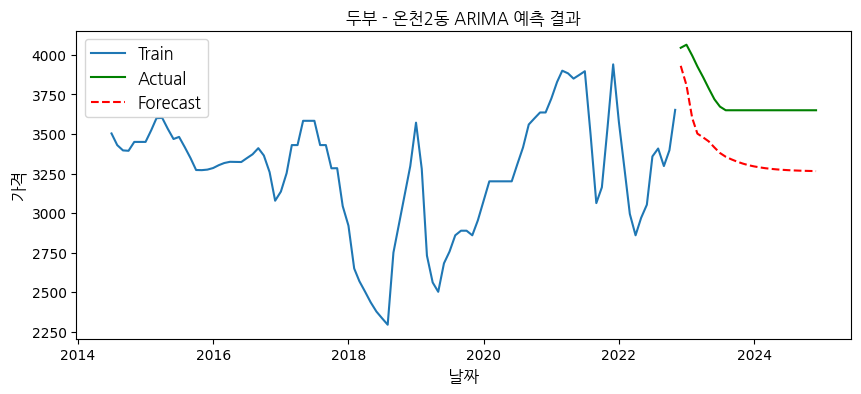

📊 평가 지표 for 두부 - 온천2동
   - AIC: 1229.1639583176318
   - BIC: 1249.9249171187084
   - RMSE: 349.505386111824 (평균 가격 대비 10.71%)
   - MAPE: 9.275948478425468%
   - Ljung-Box p-value: 0.7497607082946987 (p > 0.05이면 적절)


KeyboardInterrupt: Interrupted by user

In [32]:
#ARIMA 찾

# 🔹 1. 데이터 불러오기
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA  # ARIMA 모델
from statsmodels.stats.diagnostic import acorr_ljungbox  # Ljung-Box Test (잔차 검정)
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import matplotlib.dates as mdates


# 🔹 2. 데이터 불러오기
file_path = "/content/drive/MyDrive/khuda/대전_물가_IQR_이상치제거_결측치보완(커스텀한 1차 스플라인).csv"
df = pd.read_csv(file_path)

# 🔹 3. 날짜 변환 및 월별 평균 가격 계산
df['시간'] = pd.to_datetime(df['시간'])  # 날짜 변환
df['연월'] = df['시간'].dt.to_period('M')  # 연-월 단위 변환
df_monthly = df.groupby(['연월', '품목', '동'])['가격'].mean().reset_index()  # 동까지 포함하여 그룹화

# 🔹 '동' 컬럼의 공백 제거한 새로운 컬럼 추가
df_monthly['동_전처리'] = df_monthly['동'].str.replace(" ", "", regex=True)

# 🔹 4. 반복 입력을 통한 ARIMA 실행
while True:
    # 사용자 입력 받기
    target_items = input("분석할 품목을 입력하세요 (여러 개는 쉼표로 구분, '끝' 입력 시 종료): ")
    if target_items.strip() == "끝":
        print("✅ 분석을 종료합니다.")
        break  # 종료

    target_regions = input("분석할 동을 입력하세요 (여러 개는 쉼표로 구분): ")

    # 공백 제거 및 정리
    target_items = [item.strip() for item in target_items.split(",")]
    target_regions = [region.strip().replace(" ", "") for region in target_regions.split(",")]  # 공백 제거

    # 파일명 설정 (품목과 동을 조합하여 저장)
    file_name = f"arima_{'_'.join(target_items)}_{'_'.join(target_regions)}.csv"

    # 🔹 5. 특정 품목 + 동 조합별 ARIMA 적용
    forecast_results = []

    for item in target_items:
        for region in target_regions:
            print(f"\n Processing ARIMA for: {item} - {region}")

            # 특정 품목 + 동 조합 데이터 필터링 (공백 제거 후 비교)
            df_region = df_monthly[(df_monthly['품목'] == item) & (df_monthly['동_전처리'] == region)].copy()
            if df_region.empty:
                print(f"❌ 데이터 없음: {item} - {region}")
                continue

            df_region.set_index('연월', inplace=True)
            df_region.index = df_region.index.to_timestamp()

            # 🔸 80:20 train-test split
            split_index = int(len(df_region) * 0.8)
            train, test = df_region.iloc[:split_index], df_region.iloc[split_index:]

            # 데이터 개수가 부족하면 스킵
            if len(train) < 12:
                print(f"❌ Skipping {item} - {region} (데이터 부족)")
                continue

            # 🔸 최적의 (p, d, q) 찾기 (계절성 X)
            auto_model = auto_arima(
                train['가격'],
                seasonal=False,  # 계절성 제거
                stepwise=True,
                suppress_warnings=True
            )
            order = auto_model.order  # (p, d, q)

            # 🔸 ARIMA 모델 학습
            model = ARIMA(train['가격'], order=order)
            model_fit = model.fit()

            # 🔸 모델 평가 지표
            aic = model_fit.aic
            bic = model_fit.bic
            forecast = model_fit.forecast(steps=len(test))

            # 음수 값 방지
            forecast[forecast < 0] = 0

            rmse = np.sqrt(np.mean((test['가격'].values - forecast.values) ** 2))
            mape = np.mean(np.abs((test['가격'].values - forecast.values) / test['가격'].values)) * 100
            ljungbox_p_value = acorr_ljungbox(model_fit.resid, lags=[10], return_df=True)['lb_pvalue'].values[0]

            data_mean = train['가격'].mean()
            rmse_ratio = (rmse / data_mean) * 100

            # 🔸 결과 저장
            forecast_results.append([item, region, test.index, test['가격'].values, forecast.values, aic, bic, rmse, mape, ljungbox_p_value, *order])

            # 🔸 그래프 그리기
            plt.figure(figsize=(10, 4))
            plt.plot(train.index, train['가격'], label="Train")
            plt.plot(test.index, test['가격'], label="Actual", color='green')
            plt.plot(test.index, forecast, label="Forecast", color='red', linestyle='dashed')
            plt.title(f"{item} - {region} ARIMA 예측 결과", fontproperties=font_prop)
            plt.xlabel("날짜", fontproperties=font_prop)
            plt.ylabel("가격", fontproperties=font_prop)
            plt.legend(prop=font_prop)
            plt.show()

            print(f"📊 평가 지표 for {item} - {region}")
            print(f"   - AIC: {aic}")
            print(f"   - BIC: {bic}")
            print(f"   - RMSE: {rmse} (평균 가격 대비 {rmse_ratio:.2f}%)")
            print(f"   - MAPE: {mape}%")
            print(f"   - Ljung-Box p-value: {ljungbox_p_value} (p > 0.05이면 적절)")


